# Qboost: Binary Classification with Quantum Computer

The D-Wave quantum computer has been widely studied as a discrete optimization engine that accepts any problem formulated as quadratic unconstrained  binary  optimization  (QUBO). In 2008, Google and D-Wave published a paper, [Training a Binary Classifier with the Quantum Adiabatic Algorithm](https://arxiv.org/pdf/0811.0416.pdf), which describes how the `Qboost` ensemble method makes binary classification amenable to quantum computing: the problem is formulated as a thresholded linear superposition of a set of weak classifiers and the D-Wave quantum computer is  used to optimize the weights in a learning process that strives to minimize the training error and number of weak classifiers.

This notebook demonstrates and explains how the Qboost algorithm can be used to solve a binary classification problem. 

## A Few Words on Ensemble Methods

Ensemble methods build a strong classifier (an improved model) by combining weak classifiers with the goal of:

* decreasing variance (bagging)
* decreasing bias (boosting)
* improving prediction (voting)

![Boosting Algorithm](images/boosting.jpg)

### Bagging, Boosting, and Voting

The ensemble method produces new training data sets by random sampling with replacement from the original set. In _bagging_, any element has the same probability to appear in a new dataset; in _boosting_, data elements are weighted before they are collected in the new dataset. Another distinction is that bagging is parallelizable but boosting has to be executed sequentially. You can learn more about the differences between these methods here: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/.

Voting operates on labels only. Unlike boosting, the aggeragated classification performance is not used to further polish each weak classifier. Voting has two typical requirements of its collection of  weak classifiers: that there be __many__ and that they be __diverse__.  

## Weak and Strong Classifiers
For this reference example we chose the following four classifiers:
    1. Adaboost
    2. Decision Trees
    3. Random Forest
    4. Qboost
Note that you can replace any of these with any commonly used classification model. Also, an ensemble method can use a strong classifier instead of a weak one, and in this example we embed the Qboost classifier itself, __QboostPlus__ in the following code, with the first three.  

### Adaboost
Adaboost combines a number of $N$ weak classifiers into a strong one as
$$C(x) = sign\left(\sum_i^N w_i c_i(x)\right),$$
with $c_i(x) \in [-1, +1]$ being the $i$-th weak classifier:

$$c_i(x) = sign(w'*x + b)$$

The loss function of Adaboost is defined as
$$
L = \sum_{n=1}^N \exp\left\{ - y_n \sum_{s=1}^S w_sc_k(x_n)\right\}.
$$

The strong classifier $C(\cdot)$ is constructed in an iterative fashion. In each iteration, one weak classifier
is selected and re-learned to minimize the weighted error function. Its weight is adjusted and renormalized to make sure the sum of all weights equals 1. 

The final classification model will be decided by a weighted “vote” of all the weak classifiers. 

### Decision Trees
A decision tree builds on a tree structure with non-leaf nodes encoding decision rules and leaf nodes encoding labels. You construct a decision tree by optimizing either entropic or information-theoretic metrics. Controlling the depth of a decision tree indirectly decides the sub-dimension of the dataset. 

Decision trees are often chosen as the weak classifiers in Adaboost because they are both simple to construct and fast to do inference. The `scikit-learn` package implements its Adaboost method with decision trees of depth 1, also known as _tree stumps_. This reference examples demonstrates an alternative implementation of boosting with a number of deeper decision trees.
### Random Forest 
Random forest is an ensemble method that typically implements bagging on a set of decision trees. By introducing randomness in the selection of an optimized feature in the training of the underlying decision trees, the ensemble diversifies the weightings of its collection of weak classifiers, generally resulting in an improved model.    

### Qboost
To make use of the optimization power of D-Wave quantum annealer, we needs to formulate our objective function as a quadratic unconstrained binary optimization (QUBO) problem. Therefore, we replace the exponential loss as in Adaboost with the following quadratic loss
$$
w* = \arg\min_w\left(\sum_s \left(\frac{1}{N}\sum_n^N w_nc_n(x_s) - y_s\right)^2\right) + \lambda ||w||_0,
$$
where the regularization term is added to enable controlling of weight sparsity.

Note in Qboost, the weight vector is binary.



## Training and Comparing Performance
Now we define functions used in the following experiemnts to train our selected classifiers and provide metrics for comparing performance.

First, copy your API token.

In [3]:
% matplotlib inline

import matplotlib.pyplot as plt

import os

import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
test = pd.read_csv('./data/test.csv')
test_id = test.id
train = pd.read_csv('./data/train.csv')

In [5]:
# get coordinate information

ga_cols = []
al_cols = []
o_cols = []
in_cols = []

import warnings
warnings.filterwarnings("ignore")

for i in range(6):
    ga_cols.append("Ga_"+str(i))

for i in range(6):
    al_cols.append("Al_"+str(i))

for i in range(6):
    o_cols.append("O_"+str(i))

for i in range(6):
    in_cols.append("In_"+str(i))



ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)



for i in train.id.values:
    fn = "./data/train/{}/geometry.xyz".format(i)
    train_xyz, train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    for li in train_xyz:
        try:
            if li[1] == "Ga":
                ga_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "Al":
                al_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "In":
                in_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "O":
                o_list.append(li[0])
        except:
            pass
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    
ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

train = pd.merge(train,ga_df,on = ["id"],how = "left")
train = pd.merge(train,al_df,on = ["id"],how = "left")
train = pd.merge(train,o_df,on = ["id"],how = "left")
train = pd.merge(train,in_df,on = ["id"],how = "left")

ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

for i in test.id.values:
    fn = "./data/test/{}/geometry.xyz".format(i)
    test_xyz, test_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    for li in test_xyz:
        try:
            if li[1] == "Ga":
                ga_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "Al":
                al_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "In":
                in_list.append(li[0])
        except:
            pass
        try:
            if li[1] == "O":
                o_list.append(li[0])
        except:
            pass
    
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    

ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

test = pd.merge(test,ga_df,on = ["id"],how = "left")
test = pd.merge(test,al_df,on = ["id"],how = "left")
test = pd.merge(test,o_df,on = ["id"],how = "left")
test = pd.merge(test,in_df,on = ["id"],how = "left")

In [6]:
train.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
    'formation_energy_ev_natom' : 'E',
    'bandgap_energy_ev' : 'Eg'}, inplace=True)

test.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
}, inplace=True)


target = [
    'E',
    'Eg']

all_data = pd.concat((train, test))

## Retrieve list of elemental properties

In [7]:
def get_prop_list(path_to_element_data):
    """
    Args:
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        list of elemental properties (str) which have corresponding .csv files
    """
    return [f[:-4] for f in os.listdir(path_to_element_data)]

# folder which contains element data
path_to_element_data = './data/elemental-properties/'
# get list of properties which have data files
properties = get_prop_list(path_to_element_data)
print(sorted(properties))

['EA', 'HOMO', 'IP', 'LUMO', 'electronegativity', 'mass', 'rd_max', 'rp_max', 'rs_max']


In [8]:
def get_prop(prop, path_to_element_data):
    """
    Args:
        prop (str) - name of elemental property
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        dictionary of {element (str) : property value (float)}
    """
    fin = os.path.join(path_to_element_data, prop+'.csv')
    with open(fin) as f:
        all_els = {line.split(',')[0] : float(line.split(',')[1][:-1]) for line in f}
        my_els = ['Al', 'Ga', 'In']
        return {el : all_els[el] for el in all_els if el in my_els}

# make nested dictionary which maps {property (str) : {element (str) : property value (float)}}
prop_dict = {prop : get_prop(prop, path_to_element_data) for prop in properties}
print('The mass of aluminum is %.2f amu' % prop_dict['mass']['Al'])

The mass of aluminum is 26.98 amu


In [9]:
# average each property using the composition

def avg_prop(x_Al, x_Ga, x_In, prop):
    """
    Args:
        x_Al (float or DataFrame series) - concentration of Al
        x_Ga (float or DataFrame series) - concentration of Ga
        x_In (float or DataFrame series) - concentration of In
        prop (str) - name of elemental property
    Returns:
        average property for the compound (float or DataFrame series), 
        weighted by the elemental concentrations
    """
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [x_Al, x_Ga, x_In]))
    return np.sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

# add averaged properties to DataFrame
for prop in properties:
    all_data['_'.join(['avg', prop])] = avg_prop(all_data['x_Al'], 
                                                 all_data['x_Ga'],
                                                 all_data['x_In'],
                                                 prop)

In [10]:
# calculate the volume of the structure

def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    all_data['_'.join([lang, 'r'])] = np.pi * all_data[lang] / 180
    
# compute the cell volumes 
all_data['vol'] = get_vol(all_data['a'], all_data['b'], all_data['c'],
                          all_data['alpha_r'], all_data['beta_r'], all_data['gamma_r'])

# calculate the atomic density
all_data['atomic_density'] = all_data['Natoms'] / all_data['vol']  

In [11]:
# make new features using averages of the following columns by sg group
avg_cols = ['x_Al','x_Ga','x_In','a','b','c','avg_rs_max','avg_electronegativity',
            'avg_rp_max','avg_LUMO','avg_IP','avg_rd_max','avg_EA','avg_HOMO',
            'avg_mass','vol','atomic_density']


for col in avg_cols:
    new_col = col + "_avg"
    all_data[new_col] = np.nan
    for group in all_data['sg'].unique():
        all_data.loc[(all_data['sg'] == group), new_col] = all_data[(all_data['sg'] == group)][col].mean()

print('Number of Null Values: {}'.format(pd.isnull(all_data[avg_cols]).sum().sum()))



Number of Null Values: 0


In [12]:
# Handle the values with categorical variables using one hot encoding
# This will create a much more sparse set of variables

all_data[['sg', 'Natoms']] = all_data[['sg', 'Natoms']].astype(str)
all_data = pd.get_dummies(all_data)

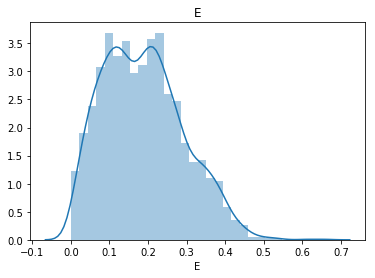

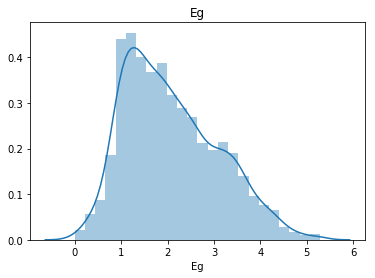

In [13]:
##Correcting Target Variables

#  both of the target variables are skewed a bit

for col in ['E', 'Eg']:
    sns.distplot((train[col]))
    plt.title(col)
    plt.show()

In [14]:
## See data

all_data.columns

Index([u'E', u'Eg', u'a', u'alpha', u'b', u'beta', u'c', u'gamma', u'id',
       u'x_Al', u'x_Ga', u'x_In', u'avg_rs_max', u'avg_electronegativity',
       u'avg_rp_max', u'avg_LUMO', u'avg_IP', u'avg_rd_max', u'avg_EA',
       u'avg_HOMO', u'avg_mass', u'alpha_r', u'beta_r', u'gamma_r', u'vol',
       u'atomic_density', u'x_Al_avg', u'x_Ga_avg', u'x_In_avg', u'a_avg',
       u'b_avg', u'c_avg', u'avg_rs_max_avg', u'avg_electronegativity_avg',
       u'avg_rp_max_avg', u'avg_LUMO_avg', u'avg_IP_avg', u'avg_rd_max_avg',
       u'avg_EA_avg', u'avg_HOMO_avg', u'avg_mass_avg', u'vol_avg',
       u'atomic_density_avg', u'Al_0_0', u'Al_1_0', u'Al_2_0', u'Al_3_0',
       u'Al_4_0', u'Al_5_0', u'Ga_0_0', u'Ga_1_0', u'Ga_2_0', u'Ga_3_0',
       u'Ga_4_0', u'Ga_5_0', u'In_0_0', u'In_1_0', u'In_2_0', u'In_3_0',
       u'In_4_0', u'In_5_0', u'Natoms_10.0', u'Natoms_20.0', u'Natoms_30.0',
       u'Natoms_40.0', u'Natoms_60.0', u'Natoms_80.0', u'O_0_0', u'O_1_0',
       u'O_2_0', u'O_3_0', u'O_4_0'

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# features to use
features = ['x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta',
            'gamma', 'vol', 'atomic_density', 'x_Al_avg','x_Ga_avg', 'x_In_avg', 'a_avg',
            'b_avg', 'c_avg', 'vol_avg', 'atomic_density_avg', 'pca_abc', 'pca_AlGaInDensity',
            'O_0_0','O_1_0', 'O_2_0', 'O_3_0', 'O_4_0', 'O_5_0', 'Al_0_0', 'Al_1_0', 'Al_2_0', 'Al_3_0', 'Al_4_0', 'Al_5_0', 'Ga_0_0',
            'Ga_1_0', 'Ga_2_0', 'Ga_3_0', 'Ga_4_0', 'Ga_5_0', 'In_0_0', 'In_1_0',
            'In_2_0', 'In_3_0', 'In_4_0', 'In_5_0',]

# two different vectors for pca
vector1 = all_data[['a', 'b', 'c']].values
vector2 = all_data[['x_Al', 'x_Ga', 'x_In', 'atomic_density_avg']].values

# use pca to add new features
pca = PCA()
pca.fit(vector1)
all_data['pca_abc'] = pca.transform(vector1)[:,0]

pca = PCA()
pca.fit(vector2)
all_data['pca_AlGaInDensity'] = pca.transform(vector2)[:,0]

# scaling the data. Linear models tend to like more normally distributed
# I tried training on non-scaled, with slightly worse results
scale = StandardScaler()
scaled = scale.fit(all_data[features]).transform(all_data[features])

X_scale = scaled[:train.shape[0]]
X_scaled_test = scaled[train.shape[0]:]

X_tr = all_data[:train.shape[0]][features].values
X_te = all_data[train.shape[0]:][features].values

y1 = np.log1p(train['E'])
y2 = np.log1p(train['Eg'])

y12 = np.column_stack((y1, y2))

X_tr.shape, y1.shape, y2.shape, y12.shape, X_scaled_test.shape

((2400, 45), (2400,), (2400,), (2400, 2), (600, 45))

In [15]:
# performance metric
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    
#     h, y = np.expm1(h), np.expm1(y)
    
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

## Gradient Boosting

In [17]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
# run different model for different Target Variables

grad_1 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=7,
                n_estimators=1120,
                max_features=7,
                min_samples_leaf=43,
                min_samples_split=14,
                min_weight_fraction_leaf=0.01556)

grad_2 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=6,
                n_estimators=3275,
                max_features=2,
                min_samples_leaf=2,
                min_samples_split=2,
                min_weight_fraction_leaf=0.08012)

def assess_grad(X, y_list, model_list):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = model_list[idx]
            model.fit(X_train, y_train)
            h =  model.predict(X_test)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print(e)
            out.append(e)
        final.append(np.array(out).mean())
                      
    return(np.array(final).mean(), np.array(final).std())

In [19]:
model = assess_grad(X_tr, [y1, y2], [grad_1, grad_2])
print("Model RMSLE: {}, std: {}".format(model[0], model[1]))

0.029005945806550977
0.03069735084928785
0.02975926791544472
0.03572537732990539
0.029012187060581226
0.029352636074113585
0.03603290932600535
0.03223846324000183
0.03199300758034223
0.03995732788489073
0.08111416745113355
0.10141046733443633
0.09357515607971809
0.09594621809346336
0.08247904492463455
0.09249171661836451
0.08787629106977207
0.08448670730987279
0.09755475553786168
0.09258166398526715
Model RMSLE: 0.0616645330736, std: 0.0292870857669


# Qboost

In [49]:
# Fill in your API token:


sapi_token = 'CDL8-df1de1d5d76560ee73a82ffca3833a1a444536d3'
url = 'https://cloud.dwavesys.com/sapi'
token = sapi_token
solver_name = 'DW_2000Q_2'

Now let us import the required packages.

In [50]:
# import necessary packages
from sklearn import preprocessing, metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets.mldata import fetch_mldata
from sklearn.datasets import load_breast_cancer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from qboost import WeakClassifiers, QBoostClassifier, QboostPlus

Next, let us define the `metric` and `train_model` functions:

In [51]:
# Define the functions required in this example

#def metric(y, y_pred):
#    """
#    :param y: true label
#    :param y_pred: predicted label
#    :return: metric score
#    """
#
#    return metrics.accuracy_score(y, y_pred)

# performance metric
def metric(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    
#     h, y = np.expm1(h), np.expm1(y)
    
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

def train_model(X_train, y_train, X_test, y_test, lmd):
    """
    :param X_train: training data
    :param y_train: training label
    :param X_test: testing data
    :param y_test: testing label
    :param lmd: lambda used in regularization
    :return:
    """

    # define parameters used in this function
    NUM_READS = 1000
    NUM_WEAK_CLASSIFIERS = 30
    TREE_DEPTH = 2
    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 'num_spin_reversal_transforms': 10,
                 'postprocess': 'optimization',
                 }

    # define sampler
    dwave_sampler = DWaveSampler(token=sapi_token, endpoint = url)
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)
    print("\n======================================")
    print("Train size: %d, Test size: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)

    # Preprocessing data
    imputer = preprocessing.Imputer()
    scaler = preprocessing.StandardScaler()
    normalizer = preprocessing.Normalizer()

    X_train = scaler.fit_transform(X_train)
    X_train = normalizer.fit_transform(X_train)

    X_test = scaler.fit_transform(X_test)
    X_test = normalizer.fit_transform(X_test)

    ## Adaboost
    print('\nAdaboost')
    clf1 = AdaBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS)
    clf1.fit(X_train, y_train)
    y_train1 = clf1.predict(X_train)
    y_test1 = clf1.predict(X_test)
#     print(clf1.estimator_weights_)
    print('accu (train): %5.2f'%(metric(y_train, y_train1)))
    print('accu (test): %5.2f'%(metric(y_test, y_test1)))

    # Ensembles of Decision Tree
    print('\nDecision tree')
    clf2 = WeakClassifiers(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf2.fit(X_train, y_train)
    y_train2 = clf2.predict(X_train)
    y_test2 = clf2.predict(X_test)
#     print(clf2.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test2)))
    
    # Random forest
    print('\nRandom Forest')
    clf3 = RandomForestClassifier(max_depth=TREE_DEPTH, n_estimators=NUM_WEAK_CLASSIFIERS)
    clf3.fit(X_train, y_train)
    y_train3 = clf3.predict(X_train)
    y_test3 = clf3.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train3)))
    print('accu (test): %5.2f' % (metric(y_test, y_test3)))

    # Qboost
    print('\nQBoost')
    clf4 = QBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf4.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print(clf4.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))

    # QboostPlus
    print('\nQBoostPlus')
    clf5 = QboostPlus([clf1, clf2, clf3, clf4])
    clf5.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train5 = clf5.predict(X_train)
    y_test5 = clf5.predict(X_test)
    print(clf5.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train5)))
    print('accu (test): %5.2f' % (metric(y_test, y_test5)))

    print("===========================================================================")
    print("Method \t Adaboost \t DecisionTree \t RandomForest \t Qboost \t Qboost+")
    print("Train\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_train, y_train1),
                                                                         metric(y_train, y_train2),
                                                                         metric(y_train, y_train3),
                                                                         metric(y_train, y_train4),
                                                                         metric(y_train, y_train5),
                                                                        ))
    print("Test\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_test, y_test1),
                                                                       metric(y_test, y_test2),
                                                                       metric(y_test, y_test3),
                                                                       metric(y_test, y_test4),
                                                                       metric(y_test, y_test5)))
    print("===========================================================================")
    
    return [clf1, clf2, clf3, clf4, clf5]

## Experiments
Now we're ready to run some experiments.
First, import the required packages. 

In [44]:
import numpy as np
#import os
import matplotlib.pyplot as plt


### Experiment 1: Binary Classfication on the MNIST Dataset 
This example transforms the MNIST dataset (handwritten digits) into a binary classification problem. We assume all digits that are smaller than 5 are labelled as -1 and the rest digits are labelled as +1.

First, let us load the MINIST dataset:

In [52]:
# 
print len(X_tr)
#y_train = [y1,y2]
y = y1

print X_tr.shape
print y1.shape

idx = np.arange(len(X_tr))
#print idx[1:5]
np.random.shuffle(idx)  # shuffles index
#print idx[1:5]

X_train = X_tr[:int(len(idx)*.8)]
y_train = y[:int(len(idx)*.8)]

X_test = X_tr[int(len(idx)*.8):]
y_test = y[int(len(idx)*.8):]

print len(X_train), len(X_test)
print("Training data size: (%d, %d)" %(X_train.shape))
print("Testing data size: (%d, %d)" %(X_test.shape))

2400
(2400, 45)
(2400,)
1920 480
Training data size: (1920, 45)
Testing data size: (480, 45)


Now train the model and compare the results of the selected classifiers.

In [53]:
# start training the model
clfs = train_model(X_train, y_train, X_test, y_test, 1.0)


Train size: 1920, Test size: 480
('Num weak classifiers:', 30)

Adaboost


ValueError: Unknown label type: 'continuous'

In [ ]:
# TODO: for this cell, Graphviz executables must be on systems PATH 
# You can optionally visualize the decision trees by uncommenting the following code
# import graphviz
# from sklearn import tree
# clf = clfs[0]
# graph = graphviz.Source(tree.export_graphviz(clf.estimators_[0], out_file=None))
# graph.render(None, view=True)

### Experiment 2: Wisconsin Breast Cancer

This example classifies tumors in scikit-learn's Wisconsis breast cancer dataset as either malignant or benign (binary classification).

First, let us load the dataset.

In [ ]:
wisc = load_breast_cancer()

idx = np.arange(len(wisc.target))
np.random.shuffle(idx)

# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]

X_train = wisc.data[idx_train]
X_test = wisc.data[idx_test]

y_train = 2 * wisc.target[idx_train] - 1  # binary -> spin
y_test = 2 * wisc.target[idx_test] - 1

In [34]:
X_train.shape
idx_01


array([25372, 17422, 39047, ..., 33089, 53898, 43637])

Now train the model and compare the results of the selected classifiers.

In [32]:
# train the model
clfs = train_model(X_train, y_train, X_test, y_test, 1.0)


Train size: 379, Test size: 190
('Num weak classifiers:', 30)

Adaboost
accu (train):  1.00
accu (test):  0.97

Decision tree
accu (train):  1.00
accu (test):  0.97

Random Forest
accu (train):  0.96
accu (test):  0.95

QBoost
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accu (train):  1.00
accu (test):  0.98

QBoostPlus
[1 1 1 1]
accu (train):  1.00
accu (test):  0.98
Method 	 Adaboost 	 DecisionTree 	 RandomForest 	 Qboost 	 Qboost+
Train	  1.00 		  1.00 		  0.96 		  1.00 		  1.00
Test	  0.97 		  0.97 		  0.95 		  0.98 		  0.98
